<a href="https://colab.research.google.com/github/shauryapatel1995/random-threading/blob/main/fatvsthin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fat and thin threads benchmarks

Benchmark machine -
Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
Number of CPUs: 4
>Cache | Cache size
>---|---
>L1d cache:|             32K
>L1i cache:|             32K
>L2 cache:|              256K
>L3 cache:|              4096K







## Workload description

# GUPS Benchmark (Fat thread)
The GUPS benchmark allocates an array per threads of 4mb size. It then randomly indexes into the array and updates the value of each index. We run the index update 1000000 times and out of these runs 85% of these updates are on unique indexes (checked over multiple runs). 

## Loop and count benchmark (Thin thread)
The Loop and count benchmark allocates an array of 0.5mb size and loops and counts all the values and returns the sum.

In [3]:
# Setup
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.stats as stats
import math

# colors = ["blue", "red", "green", "yellow"]
colors = []
for i in range(4):
  r = random.random()
  g = random.random()
  b = random.random()
  colors.append((r,g,b))

def generate_graph(threads, times, title):
  barlist = plt.bar(threads, times)
  plt.ylabel('time in ms')
  plt.xlabel('thread number')
  plt.title(title)

  for i in range(len(times)):
    barlist[i].set_color(colors[cpus[i]])

def generate_normal(mu, variance):
  sigma = math.sqrt(variance)
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma))

## Trying to predict the better configuration of running threads

## Thompson Sampling (Online learning) 
The idea is that we want to learn by running experiments how a group of threads in a process should be scheduled. To simplify this problem the current system assumes two threads and tries to find if they should run on the same core vs different cores. 

### Possible scenarios where the threads should run on the same core vs different core. 

1. If two threads share a critical section, critical section pressure would ensure that if they run on different cores then their performance will be severely affected. 

2. For two gups threads with underlying memory accesses being pareto distributions it should not matter in which configuration they are run. 

3. For two gups threads with underlying memory accesses being uniform distributions they should run on two different cores otherwise they would interfere with each other on a cache level and degrade their performance.

## Learning model 
The learning model we used was modelling a posterior reward distribution using a normal distribution. 
When we run an experiment of an Action we update its posterior. Here we assume that there are just two actions, scheduling on the same core and scheduling on different cores. 

We need to update the posterior after an experiment for that we maintain the running mean and update it with the ground truth running time. In order to give higher reward to the action with lower running time we add (1/running_time) to the mean, we set the standard deviation to (1/num_trials) to reinforce our mean if we have higher number of trials. 

To select which action to run next we sample the probability of reward from the posterior and select the action with a higher reward. 

## Scenario 1 
Two threads sharing a critical section with high critical section pressure. 

Final number of trials 

Same CPU - 94 times selected.

Different CPUs - 5 times selected.

The posterior distributions across various trials are 

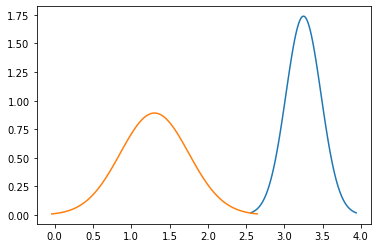

In [9]:
## 25 trials. 
generate_normal(3.25025, float(1/19))
generate_normal(1.30388, float(1/5))
plt.show()

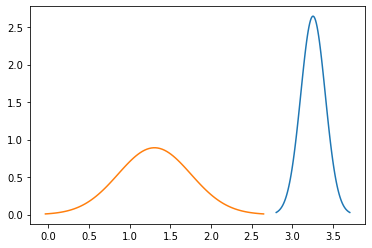

In [10]:
## 50 trials 
generate_normal(3.25377, float(1/44))
generate_normal(1.30388, float(1/5))
plt.show()

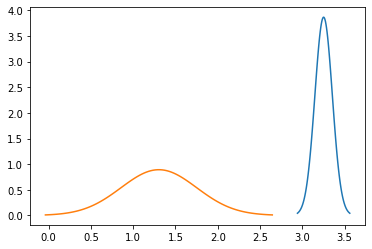

In [11]:
# 100 trials 
generate_normal(3.25233, float(1/94))
generate_normal(1.30388, float(1/5))
plt.show()

## Scenario 2 
Two GUPS processes running pareto distribution comparing different kinds of rewards. 100/t, 10/t, 1/t.

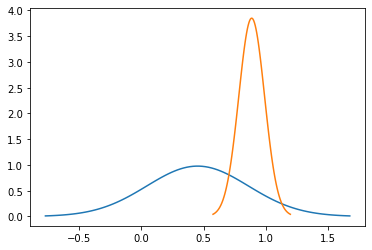

In [12]:
## 100 trials with 100/t as reward
generate_normal(0.452158, float(1/6))
generate_normal(0.887375, float(1/93))
plt.show()

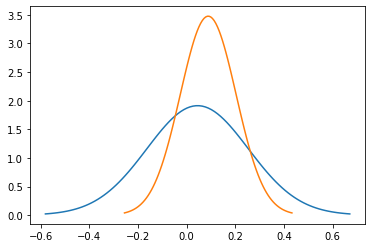

In [13]:
# 100 trials with 10/t as reward
generate_normal(0.0452417, float(1/23))
generate_normal(0.088832, float(1/76))
plt.show()

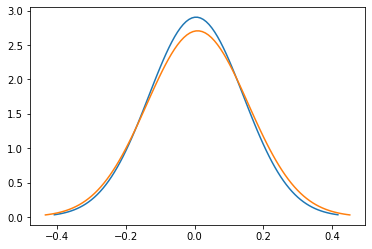

In [14]:
# 100 trials with 1/t reward
generate_normal(0.00452385, float(1/53))
generate_normal(0.0088643, float(1/46))
plt.show()

## Scenario 3 
Running two gups processes following uniform distribution with reward 100/t

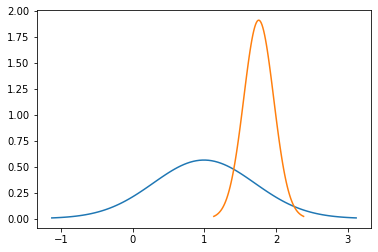

In [15]:
# 25 trials
generate_normal(0.99505, float(1/2))
generate_normal(1.75809, float(1/23))
plt.show()

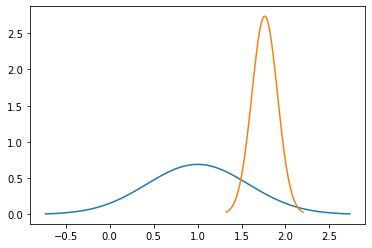

In [16]:
# 50 trials 
generate_normal(1.00007, float(1/3))
generate_normal(1.76377, float(1/47))
plt.show()

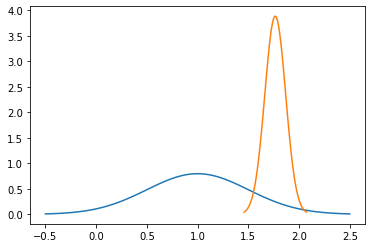

In [20]:
# 100 trials, we give much more weight to different processors and out bounds of that are also well defined due to confidence of deviation
generate_normal(1.00005, float(1/4))
generate_normal(1.76538, float(1/95))
plt.show()

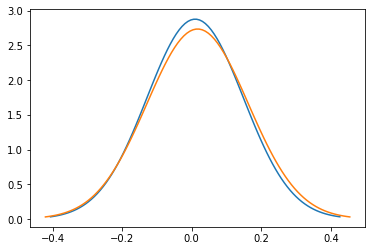

In [19]:
# 100 trials with reward 1/t, 1/t makes it too close for us to decide which is the correct action to choose
generate_normal(0.0099905, float(1/52))
generate_normal(0.0169754, float(1/47))
plt.show()

### Fat thread experiments
Unless mentioned same color indicates same CPU

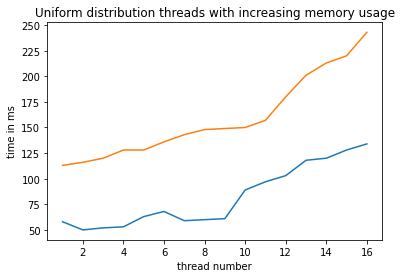

In [ ]:
# Uniform distribution memory increments comparison
single_fat = [58, 50, 52, 53, 63, 68, 59, 60, 61, 89, 97, 103, 118, 120, 128, 134]
fat_2 = [113, 116, 120, 128, 128, 136, 143, 148, 149, 150, 157, 180, 201, 213, 220, 243]
#memory_sizes = [100000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]
memory_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.plot(memory_sizes, single_fat, memory_sizes, fat_2)
plt.ylabel('time in ms')
plt.xlabel('thread number')
plt.title('Uniform distribution threads with increasing memory usage')
plt.show()

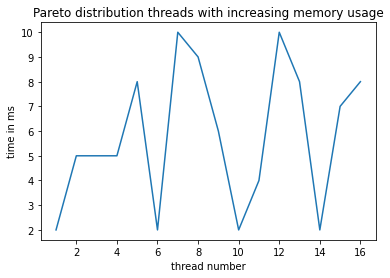

In [ ]:
# Pareto distribution memory increments comparison
single_fat = [2, 5, 5, 5, 8, 2, 10, 9, 6, 2, 4, 10, 8, 2, 7, 8]
#memory_sizes = [100000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000, 4000000]
memory_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
plt.ylabel('time in ms')
plt.xlabel('thread number')
plt.title('Pareto distribution threads with increasing memory usage')
plt.plot(memory_sizes, single_fat)
plt.show()

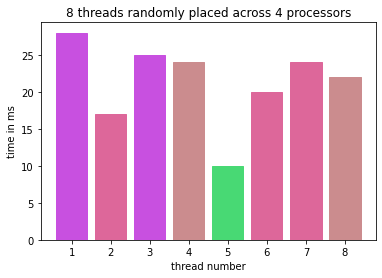

In [ ]:
#Pareto distribution 8 threads - 4 fat and 4 thin
times = [28, 17, 25, 24, 10, 20, 24, 22]
threads = [1,2,3,4,5,6,7,8]
cpus = [0,3,0,2,1,3,3,2]
generate_graph(threads, times, '8 threads randomly placed across 4 processors')
plt.show()

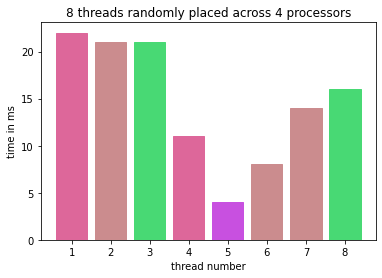

In [ ]:
#Pareto distribution 8 threads - 4 fat and 4 thin
times = [22, 21, 21, 11, 4, 8, 14, 16]
threads = [1,2,3,4,5,6,7,8]
cpus = [3,2,1,3,0,2,2,1]
generate_graph(threads, times, '8 threads randomly placed across 4 processors')
plt.show()

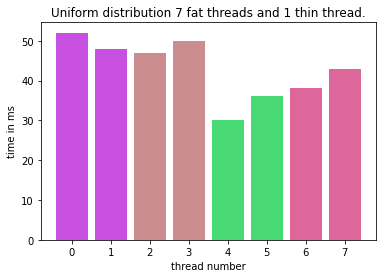

In [ ]:
# Uniform distribution with 7 fat threads and 1 thin thread. Fat thread memory consumption is 2mb.
# Thread 4 and 5 are colocated thin and fat thread on processor 1. 
times = [52, 48, 47, 50, 30, 36, 38, 43]
threads = [x for x in range(8)]
cpus = [0,0,2,2,1,1,3,3]
generate_graph(threads, times, 'Uniform distribution 7 fat threads and 1 thin thread.')
plt.show()

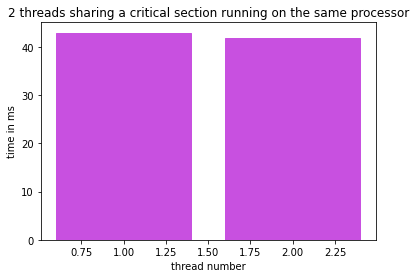

In [ ]:
# mutex contetion benchmark
# We use a simple loop and count with a global variable and a mutex to lock that variable between two threads.
times = [43, 42]
threads = [1,2]
cpus = [0,0]
generate_graph(threads, times, '2 threads sharing a critical section running on the same processor')
plt.show()

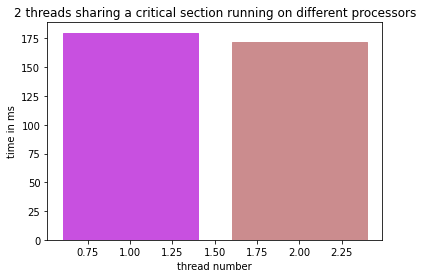

In [ ]:
# mutex contetion benchmark
# We use a simple loop and count with a global variable and a mutex to lock that variable between two threads. 
# We ran the threads on different processors. 
times = [180, 172]
threads = [1,2]
cpus = [0,2]
generate_graph(threads, times, '2 threads sharing a critical section running on different processors')
plt.show()

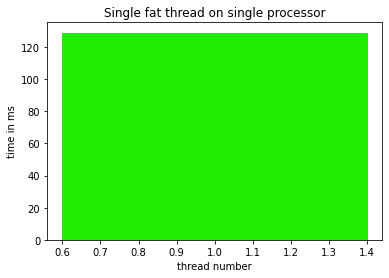

In [ ]:
times = [129]
threads = [1]
cpus = [0]
generate_graph(threads, times, 'Single fat thread on single processor')

plt.show()

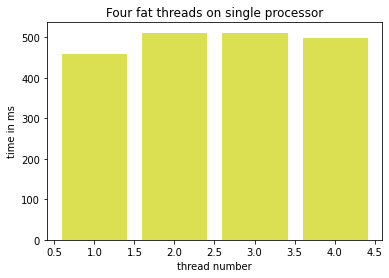

In [ ]:
times =[458, 511, 511, 499]
threads = [1,2,3,4]
cpus = [0,0,0,0]
generate_graph(threads, times, 'Four fat threads on single processor')

plt.show()

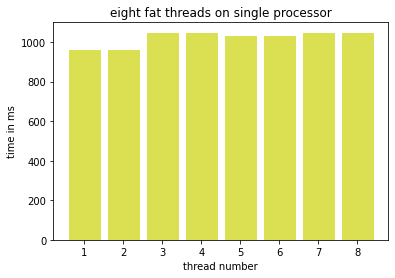

In [ ]:
times =[960, 960, 1047, 1046, 1029, 1032, 1046, 1044]
threads = [1,2,3,4, 5, 6, 7, 8]
cpus = [0,0,0,0,0,0,0,0]
generate_graph(threads, times, 'eight fat threads on single processor')
plt.show()

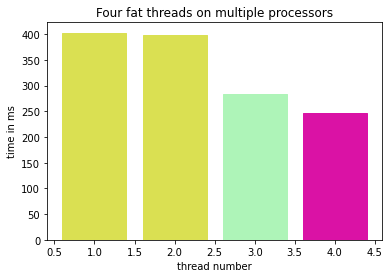

In [ ]:
times = [403, 398, 283, 246]
threads = [1,2,3,4]
cpus = [0,0,2,1]
generate_graph(threads, times, 'Four fat threads on multiple processors')
plt.show()

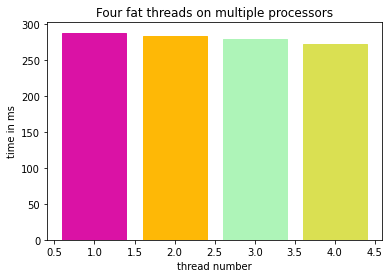

In [ ]:
times = [288, 284, 279, 273]
threads = [1,2,3,4]
cpus = [1,3,2,0]
generate_graph(threads, times, 'Four fat threads on multiple processors')

plt.show()

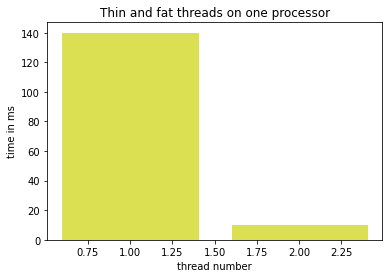

In [ ]:
times = [140, 10]
threads = [1,2]
cpus = [0,0]
generate_graph(threads, times, 'Thin and fat threads on one processor')
plt.show()

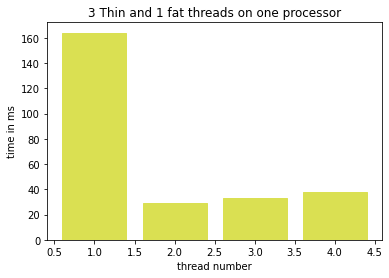

In [ ]:
times = [164, 29, 33, 38]
threads = [1,2, 3, 4]
cpus = [0,0, 0, 0]

generate_graph(threads, times, '3 Thin and 1 fat threads on one processor')
plt.show()

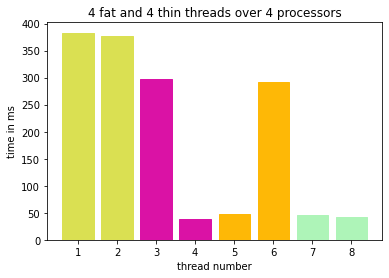

In [ ]:
times = [383, 376, 298, 38, 47, 292, 46, 42]
threads = [1,2,3,4,5,6,7,8]
cpus = [0,0,1,1,3,3,2,2]
generate_graph(threads, times, '4 fat and 4 thin threads over 4 processors')
plt.show()

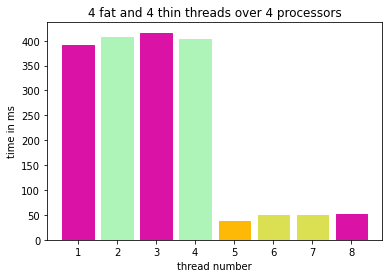

In [ ]:
times = [392, 407, 416, 404, 38, 50, 49, 51]
threads = [1,2,3,4,5,6,7,8]
cpus = [1,2,1,2,3,0,0,1]
generate_graph(threads, times, '4 fat and 4 thin threads over 4 processors')
plt.show()